In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mpl_toolkits import mplot3d
from matplotlib import cm
import itertools

## 1. Regularization and Hyper Parameter Tuning

### A. Extending the Optimization Routines and Loss Functions

In [2]:
class Functions:
    
    ## function for random sampling of data
    def random_sampler(self, perc=0.1):
        prop = int(len(self.X)*perc) #proportion of the data to be used for each iteration, here we have set it to 10% of the data
        ind = np.random.choice(range(len(self.X)), prop, replace=False)
        test_ind = list(set(range(len(self.X))) - set(ind)) #for using the rest sample as test set
        return self.X[ind],self.y[ind], self.X[test_ind], self.y[test_ind]
    
    ## funtion for normalizing the features
    def normalize_features(self,X,append=True):
        X = (X - np.mean(X, 0)) / np.std(X, 0) #normalize the features
        if append:
            X = np.append(np.ones(X.shape[0]).reshape(-1,1),X,1) #append column of ones for intercept
        return X
    
    ## function for calculating the loss trajectory for the test set given the loss function and the betas
    def calculate_test_loss_trajectory(self, X, y, beta_list, penalty, loss_fn):
        loss = []
        for beta in beta_list:
            l, _, _ = loss_fn(X, y, beta.reshape(-1,1),penalty=penalty)
            loss.append(l)
        return loss
            
    ## for calculating the metrics
    def calculate_metrics(self, y, preds):
        
        ## accuracy is given by
        accuracy = 1-np.sum(np.abs(np.subtract(preds,y)))/len(preds)
        
        ## calculate the True Positives TP
        Tp = np.sum((y == True) & (preds == True))
        
        ## calculate the True Negatives TN
        Tn = np.sum((y == False) & (preds == False))
        
        ## calculate the False Positives FP
        Fp = np.sum((y == False) & (preds == True))
        
        ## calculate the False Negatives FN
        Fn = np.sum((y == True) & (preds == False))
        
        ## calculate the Precision P
        P = Tp/(Tp+Fp)
        
        ## calculate the Recall
        R = Tp/(Tp+Fn)
        
        ## calculate the F1 score
        F = 2/(1/P+1/R)
        
        ## making confusion matrix
        c = np.ones(4)
        c[0],c[1],c[2],c[3] = Tn, Fp, Fn, Tp
        c = c.reshape(2,2)
        
        print('The accuracy of the model is',accuracy)
        print('The Precision of the model is',P)
        print('The Recall of the model is',R)
        print('The F-Score of the model is',F)
        print('The Confusion Matrix formed by the model is \n',c)
    

In [3]:
class Optimization(Functions):
    
    ## initializing class
    def __init__(self, X, y, loss, lr=1, penalty=0.01):
        self.X = X
        self.y = y
        self.loss = loss
        self.lr = lr
        self.penalty = penalty
    
    ## Step-Length Controller
    def Bold_Driver(self, curr_loss, prev_loss, lr):
        if prev_loss <= curr_loss:
            lr = lr*0.5
        else:
            lr = lr*1.05
        return lr
    
    ## stochastic gradient descent function
    def SGD(self, B, max_iter=1000,tolerance=1e-6,controller=True):
        #function for updating parameters using SGD
        loss_list = []
        #test_loss_list=[]
        B_history = []
        prev_loss = -np.inf #previous loss used by step length controller
        lr = self.lr
        for it in range(max_iter):
            #sample a random x and y batch for training and validation
            x, y, x_test,y_test = self.random_sampler()
            
            #calculating the loss
            curr_loss, derv_loss, _ = self.loss(self, x, y, B, penalty=self.penalty)
            loss_list.append(curr_loss)
            
            #curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            #test_loss_list.append(curr_loss_test)
            B_history.append(list(B.reshape(1,-1)))
            
            #Adaptive Step length controller
            if controller and (it != 0):
                lr = self.Bold_Driver(curr_loss,prev_loss,lr)
            
            #update the betas
            e = lr*derv_loss
            B = B - e
            
            if np.all(np.abs(derv_loss**2) <= tolerance):
                break
            
            #set previous loss to current loss
            prev_loss = curr_loss
            
        return B,loss_list,np.squeeze(np.array(B_history),1)
    
    ## Newton Method for Optimization
    def newton_optimization(self, B, max_iter=1000, tolerance = 1e-4):
        ## function for updating parameters using newton's method
        loss_list = []
        test_loss_list=[]
        x, y, x_test, y_test = self.random_sampler(perc = 0.80) # use 80-20 in the training too
        lr = self.lr
        for it in range(max_iter):
            #calculate training loss
            curr_loss, gradient, hessian = self.loss(self, x, y, B, penalty=self.penalty)
            loss_list.append(curr_loss)
            
            #calculate test loss
            curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            test_loss_list.append(curr_loss_test)
            
            ## newton method
            e = -np.linalg.solve(hessian,gradient)
            B = B + lr*e
            
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                break
                
        return B,loss_list,test_loss_list

In [4]:
class Loss():
    ## mean square error loss which returns loss, first derivative and hessian
    def mean_square_loss(self, X, y, betas, penalty=None):
        N = len(X)
        pred = np.dot(X,betas)
        loss = (np.square(y-pred)).mean()
        gradient = (-2.0 /N) * X.T.dot(y - X.dot(betas))
        hessian = 1/N * np.matmul(X.T,X)
        return loss, gradient, hessian
    
    ## cross entropy loss
    def cross_entropy_loss(self, X, y, B, penalty=None):
        N = len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        W = 1/N * np.diag((p*(1-p)).reshape(-1))
        loss = (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))))
        gradient = -1/N * np.dot(X.T,(y-p))
        hessian = X.T@W@X
        return loss, gradient, hessian
    
    ## weighted cross entropy loss
    def weighted_cross_entropy(self, X, y, B, penalty=None):
        N = len(X)
        unique, counts = np.unique(y, return_counts=True) ##count number of classes and their frequency of occurance
        n_0, n_1 = counts
        w_0 = (n_0 + n_1) / (2.0 * n_0) #weights for negative class
        w_1 = (n_0 + n_1) / (2.0 * n_1) #weights for positive class

        ## create a case weight vector first
        CW = np.full_like(y,1,dtype=np.float32) #of same shape as y
        CW[y==1] = w_1 #replacing with the pos_weight
        CW[y==0] = w_0 #replacing with the neg_weight

        ## calculating the loss
        p = 1./(1+np.exp(-np.dot(X,B)))
        #e = 1e-20 #for numerical stability
        loss = (-1/N * (np.dot(np.multiply(CW,y).T,np.log(p))+np.dot(np.transpose(1-np.multiply(CW,y)),np.log(1-p))))[0][0]
        gradient = -1/N * np.dot(X.T,np.multiply(CW,(y-p)))
        W = 1/N * np.diag(np.multiply(CW,(p*(1-p))).reshape(-1))
        hessian = X.T@W@X
        return loss, gradient, hessian

    # Cross entropy with L2 regularization
    def L2_regularized_cross_entropy_loss(self, X, y, B, penalty=0.01):
        N=len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        #e = 1e-20 #for numerical stability
        W = 2/N * penalty * np.diag((p*(1-p)).reshape(-1))
        loss = (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))) + penalty*B.T.dot(B))[0][0]
        gradient = -1/N * np.dot(X.T,(y-p)) + 2*penalty*B
        hessian = X.T@W@X 
        return loss, gradient, hessian
    
    # Cross entropy with L1 regularization
    def L1_regularized_cross_entropy_loss(self, X, y, B, penalty=0.01):
        N=len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        #e = 1e-20 #for numerical stability
        W = 1/N * np.diag((p*(1-p)).reshape(-1))
        loss = (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))) + penalty*np.sum(np.abs(B)))[0][0]
        gradient = -1/N * np.dot(X.T,(y-p)) + penalty * np.sign(B)
        hessian = X.T@W@X
        return loss, gradient, hessian
    
    # Bonus: Elastic Net
    def Elastic_Net(self, X, y, B, penalty=0.01):
        N=len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        #e = 1e-20 #for numerical stability
        W = 2/N * penalty * np.diag((p*(1-p)).reshape(-1))
        loss = (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))) + penalty*np.sum(np.abs(B)) + penalty*B.T.dot(B))[0][0]
        gradient = -1/N * np.dot(X.T,(y-p)) + penalty * np.sign(B) + 2*penalty*B
        hessian = X.T@W@X
        return loss, gradient, hessian

### B. Regularization and Model Selection

In [5]:
## Make a logistic Regression class which takes X, y and loss function as input
class LogisticRegression():
    def __init__(self, X, y, loss, controller=True):
        self.X = X
        self.y = y
        self.loss = loss
        self.controller = controller
        
    def fit(self, max_iter= 50, tolerance=1e-6, lr=1, penalty=0.001):         
        # generate a random Beta matrix for 1st iteration
        B = np.zeros((self.X.shape[1],1)) 
        
        ## define optimizer
        optim = Optimization(self.X, self.y, self.loss, lr, penalty)
        B, loss, B_history = optim.SGD(B, max_iter, tolerance, controller=self.controller)
        self.B = B
        return B,loss,B_history
    
    def predict(self,X):
        scores = np.matmul(X,self.B)
        return 1./(1+np.exp(-scores))

In [6]:
## reading the data
log_reg_data = pd.read_csv('logistic.csv')
## mapping Y values between 0 and 1
log_reg_data['Y'] = log_reg_data['Y'].replace({'M':1,'B':0})
#splititng data into x and y
X = log_reg_data.iloc[:,1:]
y = log_reg_data.iloc[:,0]
## let's split the data into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train_normalized = Functions().normalize_features(X_train)
X_test_normalized = Functions().normalize_features(X_test)

##### 1. Cross Entropy Loss and Stochastic Gradient Descent

In [8]:
# Making the model
log_reg_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.cross_entropy_loss)
log_reg_model_params,train_loss,B_history = log_reg_model.fit()
test_loss = Functions().calculate_test_loss_trajectory(X_test_normalized,y_test.values.reshape(-1,1),B_history,None,Loss().cross_entropy_loss)

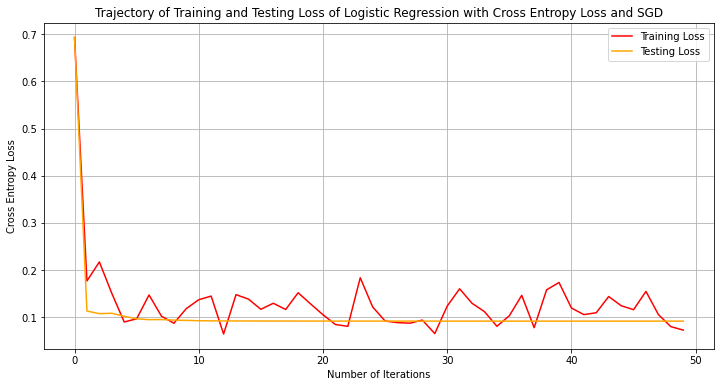

In [9]:
train_loss = np.vstack(np.array(train_loss)).reshape(-1)
test_loss = np.vstack(np.array(test_loss)).reshape(-1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression with Cross Entropy Loss and SGD');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

In [10]:
log_reg_model_test = log_reg_model.predict(X_test_normalized) > 0.5
log_reg_model_train = log_reg_model.predict(X_train_normalized) > 0.5
print('The Final Train accuracy of Cross Entropy with SGD is', accuracy_score(y_train,log_reg_model_train))
print('The Final Test accuracy of Cross Entropy with SGD is', accuracy_score(y_test,log_reg_model_test))

The Final Train accuracy of Cross Entropy with SGD is 0.9692307692307692
The Final Test accuracy of Cross Entropy with SGD is 0.9912280701754386


##### 2. Balanced Cross Entropy Loss and Stochastic Gradient Descent

In [11]:
# Making the model
log_reg_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.weighted_cross_entropy)
log_reg_model_params,train_loss,B_history = log_reg_model.fit()
test_loss = Functions().calculate_test_loss_trajectory(X_test_normalized,y_test.values.reshape(-1,1),B_history,None,Loss().weighted_cross_entropy)

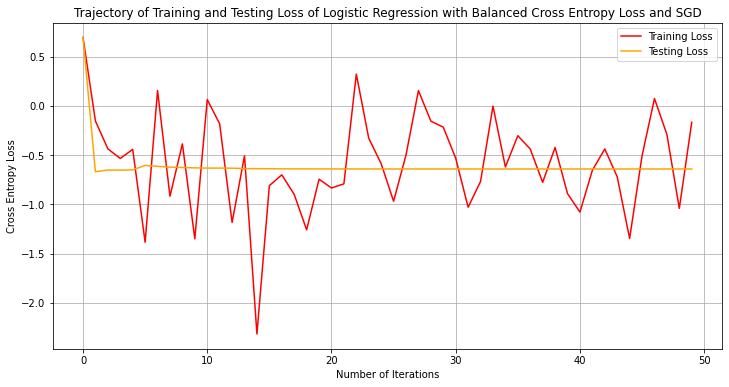

In [12]:
train_loss = np.vstack(np.array(train_loss)).reshape(-1)
test_loss = np.vstack(np.array(test_loss)).reshape(-1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression with Balanced Cross Entropy Loss and SGD');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

In [13]:
log_reg_model_test = log_reg_model.predict(X_test_normalized) > 0.5
log_reg_model_train = log_reg_model.predict(X_train_normalized) > 0.5
print('The Final Train accuracy of Balanced Cross Entropy with SGD is', accuracy_score(y_train,log_reg_model_train))
print('The Final Test accuracy of Balanced Cross Entropy with SGD is', accuracy_score(y_test,log_reg_model_test))

The Final Train accuracy of Balanced Cross Entropy with SGD is 0.9714285714285714
The Final Test accuracy of Balanced Cross Entropy with SGD is 0.9824561403508771


##### 3. L1 Regularized Cross Entropy Loss and Stochastic Gradient Descent

In [14]:
# Making the model
log_reg_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.L1_regularized_cross_entropy_loss)
log_reg_model_params,train_loss,B_history = log_reg_model.fit()
test_loss_L1 = Functions().calculate_test_loss_trajectory(X_test_normalized,y_test.values.reshape(-1,1),B_history,0.01,Loss().L1_regularized_cross_entropy_loss)

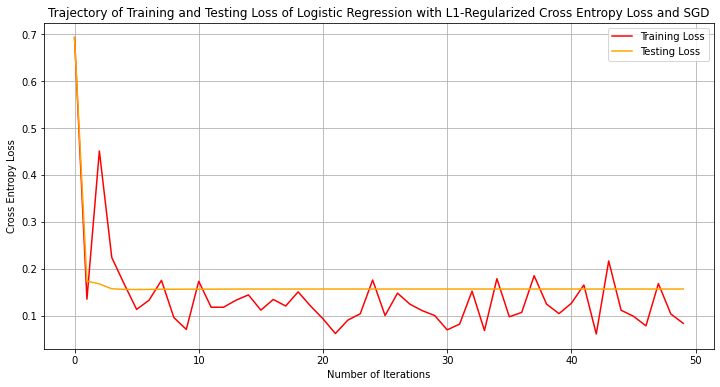

In [15]:
train_loss = np.vstack(np.array(train_loss)).reshape(-1)
test_loss_L1 = np.vstack(np.array(test_loss_L1)).reshape(-1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss_L1)),test_loss_L1,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression with L1-Regularized Cross Entropy Loss and SGD');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

In [16]:
log_reg_model_test = log_reg_model.predict(X_test_normalized) > 0.5
log_reg_model_train = log_reg_model.predict(X_train_normalized) > 0.5
print('The Final Train accuracy of L1-Regularized Cross Entropy with SGD is', accuracy_score(y_train,log_reg_model_train))
print('The Final Test accuracy of L1-Regularized Cross Entropy with SGD is', accuracy_score(y_test,log_reg_model_test))

The Final Train accuracy of L1-Regularized Cross Entropy with SGD is 0.9692307692307692
The Final Test accuracy of L1-Regularized Cross Entropy with SGD is 0.9912280701754386


##### 4. L2 Regularized Cross Entropy Loss and Stochastic Gradient Descent

In [17]:
# Making the model
log_reg_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.L2_regularized_cross_entropy_loss)
log_reg_model_params,train_loss,B_history = log_reg_model.fit()
test_loss_L2 = Functions().calculate_test_loss_trajectory(X_test_normalized,y_test.values.reshape(-1,1),B_history,0.01,Loss().L2_regularized_cross_entropy_loss)

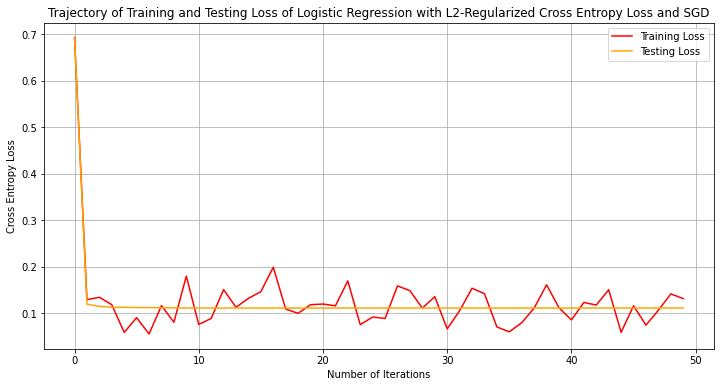

In [18]:
train_loss = np.vstack(np.array(train_loss)).reshape(-1)
test_loss_L2 = np.vstack(np.array(test_loss_L2)).reshape(-1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss_L2)),test_loss_L2,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression with L2-Regularized Cross Entropy Loss and SGD');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

In [19]:
log_reg_model_test = log_reg_model.predict(X_test_normalized) > 0.5
log_reg_model_train = log_reg_model.predict(X_train_normalized) > 0.5
print('The Final Train accuracy of L2-Regularized Cross Entropy with SGD is', accuracy_score(y_train,log_reg_model_train))
print('The Final Test accuracy of L2-Regularized Cross Entropy with SGD is', accuracy_score(y_test,log_reg_model_test))

The Final Train accuracy of L2-Regularized Cross Entropy with SGD is 0.967032967032967
The Final Test accuracy of L2-Regularized Cross Entropy with SGD is 0.9824561403508771


##### 5. Bonus: Elastic Net

In [20]:
# Making the model
log_reg_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.Elastic_Net)
log_reg_model_params,train_loss,B_history = log_reg_model.fit()
test_loss_en = Functions().calculate_test_loss_trajectory(X_test_normalized,y_test.values.reshape(-1,1),B_history,0.01,Loss().L2_regularized_cross_entropy_loss)

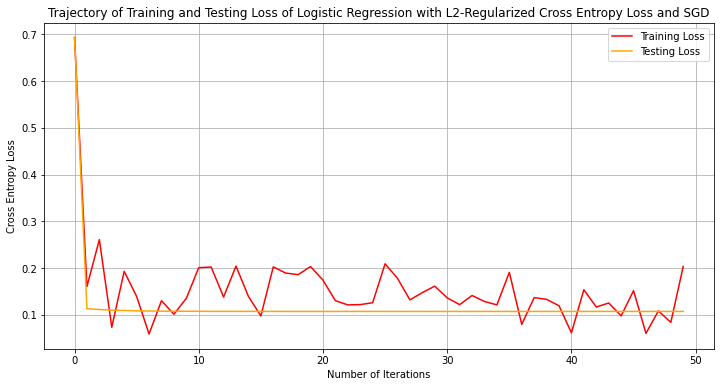

In [21]:
train_loss = np.vstack(np.array(train_loss)).reshape(-1)
test_loss_en = np.vstack(np.array(test_loss_en)).reshape(-1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss_en)),test_loss_en,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression with L2-Regularized Cross Entropy Loss and SGD');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

In [22]:
log_reg_model_test = log_reg_model.predict(X_test_normalized) > 0.5
log_reg_model_train = log_reg_model.predict(X_train_normalized) > 0.5
print('The Final Train accuracy of Elastic-Net Cross Entropy with SGD is', accuracy_score(y_train,log_reg_model_train))
print('The Final Test accuracy of Elastic-Net Cross Entropy with SGD is', accuracy_score(y_test,log_reg_model_test))

The Final Train accuracy of Elastic-Net Cross Entropy with SGD is 0.9560439560439561
The Final Test accuracy of Elastic-Net Cross Entropy with SGD is 0.9824561403508771


Comparision between L1, L2 and Elastic Net

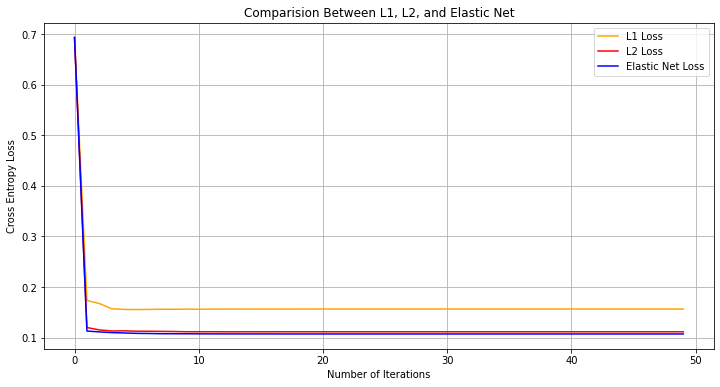

In [23]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(test_loss_L1)),test_loss_L1,color='orange',label='L1 Loss')
plt.plot(np.arange(len(test_loss_L2)),test_loss_L2,color='red',label='L2 Loss')
plt.plot(np.arange(len(test_loss_en)),test_loss_en,color='blue',label='Elastic Net Loss')
plt.title('Comparision Between L1, L2, and Elastic Net');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

#### Backward Selection using AIC

In [24]:
#making copy of the original data so it remains intact
d = X_train.copy()

t = Functions().normalize_features(d)
#calculate the total AIC when we use all features
log_model = LogisticRegression(t,y_train.values.reshape(-1,1),Loss.cross_entropy_loss)
B, _, _ = log_model.fit()

#calculate log Likelihood on training data
LL, _, _ = Loss().cross_entropy_loss(t, y_train.values.reshape(-1), B, penalty=None)

#calculate total AIC
TOTAL_AIC = 2*LL*len(y_train) + 2 * t.shape[1]

In [25]:
bad_features = [] #list to store values of features that when removed reduces the AIC most
aic_without_bad_features = [] #list to store values of AIC after dropping each feature
while len(d.columns)>0:
    aic_dict = {}
    #iterating over all columns and dropping them
    for col in d.columns:
        t = d.drop(col,axis=1) #dropping the column and stroing the rest into temp variable
        t = Functions().normalize_features(t) #normalizing those features

        #fit a model
        log_model = LogisticRegression(t,y_train.values.reshape(-1,1),Loss.cross_entropy_loss)
        B, _, _ = log_model.fit()

        #calculate log Likelihood on training data
        LL, _, _ = Loss().cross_entropy_loss(t, y_train.values.reshape(-1), B, penalty=None)

        #calculate AIC
        AIC = 2*LL*len(y_train) + 2 * t.shape[1]

        #append the AIC values by dropping all columns
        aic_dict[col] = AIC

    #get the column which drops the AIC most
    bad_feature = min(aic_dict, key=aic_dict.get)
    
    #store the corresponding value
    aic_without_bad_features.append(aic_dict[bad_feature])

    #store the bad features history
    bad_features.append(bad_feature)

    #dropping that column to not be included in next round
    d = d.drop(bad_feature,axis=1)

In [26]:
#to separate out useful features, find the features combination which when used give the lowest AIC
useful_features = bad_features[np.argmin(aic_without_bad_features) + 1:]

In [27]:
print('The important features based on Backward Selection are',useful_features)

The important features based on Backward Selection are ['X8', 'X30', 'X3', 'X14', 'X19', 'X7', 'X11', 'X2', 'X26', 'X16', 'X24', 'X25', 'X20', 'X22', 'X13', 'X29', 'X23']


## 2. K-Fold Cross Validation

In [28]:
##function to split the data into a desired number of folds
def split_kfolds(data,targets,kfolds):
    data = np.copy(data) #make copy of data
    targets = np.copy(targets) #make copy of targets
    np.random.shuffle(data) ## randomly shuffle the data
    prop = (np.arange(0,1.1,1/kfolds)*len(data)).astype(int) ##proportion of data to be picked in each batch of fold
    i = 0 #counter
    data_chunks = []
    target_chunks = []
    while i<len(prop)-1:
        d = data[prop[i]:prop[i+1],:] ##pick a chunk of data
        t = targets[prop[i]:prop[i+1]] ##pick a chunk of target
        data_chunks.append(d) ##append the chunk of data
        target_chunks.append(t) ##append the chunk of target
        i+=1
    return np.array(data_chunks,dtype=object),np.array(target_chunks,dtype=object)

In [29]:
#to obtain the splitted data
fold_data,fold_target = split_kfolds(X_train_normalized,y_train,3)

In [30]:
#list of params to be used in grid search
lr_list = [0.001,0.01,0.1,0.2,0.5,0.4,0.7,1]
penalty_list = [0.01,0.1,0.2,0.4,0.5]
kfolds=3

In [31]:
#function to do grid search with K-folds
def grid_search(fold_data,fold_target,kfolds,lr_list,penalty_list):
    combinations = itertools.product(lr_list,penalty_list) #all possible combination of hyper params
    fold_accuracy = []
    lrs = []
    penalties = []
    for combo in combinations:
        lr, penalty = combo
        mean_accuracy = []
        for n in range(kfolds):
            s = list(range(kfolds)) #index list
            test_ind = s.pop(n) #index used for testing
            train_ind = s #index used for training

            #splitting into training data and targets
            train_data = np.vstack(fold_data[train_ind])
            train_target = np.hstack(fold_target[train_ind])

            #splitting into testing data and targets
            test_data = fold_data[test_ind]
            test_target = fold_target[test_ind]

            #defining the model here the bold driver is turned off
            model = LogisticRegression(train_data,train_target.reshape(-1,1),Loss.L2_regularized_cross_entropy_loss,controller=False)

            ##fitting the model
            log_reg_model_params,_,_ = model.fit(lr=lr, penalty=penalty)

            ##testing the fitted model on one fold
            preds = model.predict(test_data)>0.5

            ##calculating accuracy 
            mean_accuracy.append(accuracy_score(test_target.reshape(-1,1),preds))

        lrs.append(lr)
        penalties.append(penalty)
        #To keep track of the mean performance across the k-folds for each of the hyper parameters
        fold_accuracy.append(np.mean(mean_accuracy))
    return lrs,penalties,fold_accuracy

In [32]:
#running grid search
l, p, a = grid_search(fold_data,fold_target,3,lr_list,penalty_list)

In [33]:
idmax = np.argmax(a)
best_l = l[idmax]
best_p = p[idmax]
print('The best value for LR and Penalty are',best_l,best_p)

The best value for LR and Penalty are 0.1 0.01


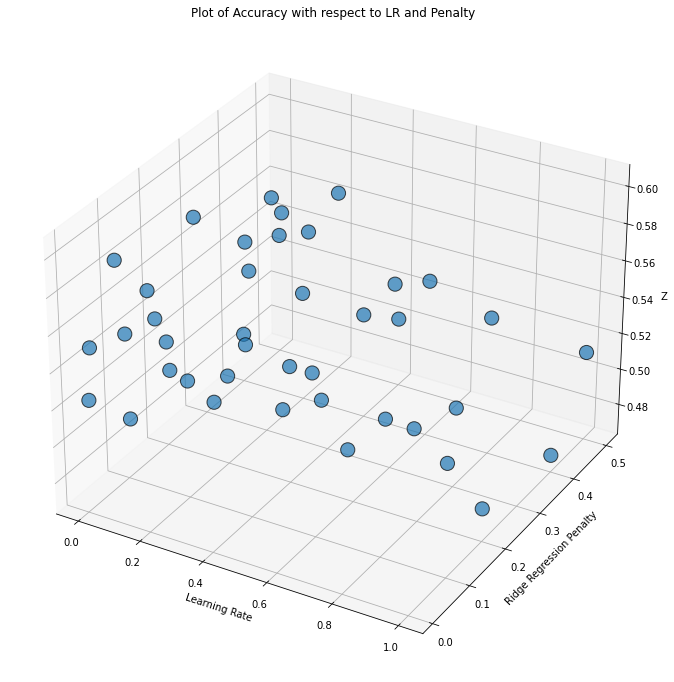

In [34]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l, p, a,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,);

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Ridge Regression Penalty')
ax.set_zlabel('Z');
ax.set_title('Plot of Accuracy with respect to LR and Penalty');

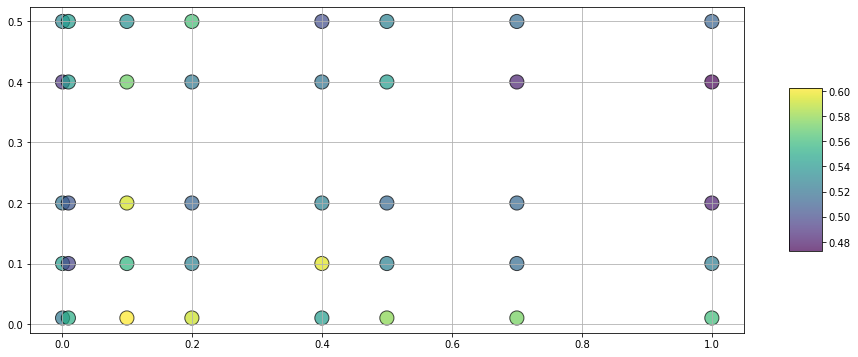

In [35]:
#In 2D the plot looks like
fig = plt.figure(figsize=(16, 6))
g = plt.scatter(l, p,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=a)
fig.colorbar(g, shrink=0.5, aspect=5);
plt.grid('on');

Also Plot the Surface Plot

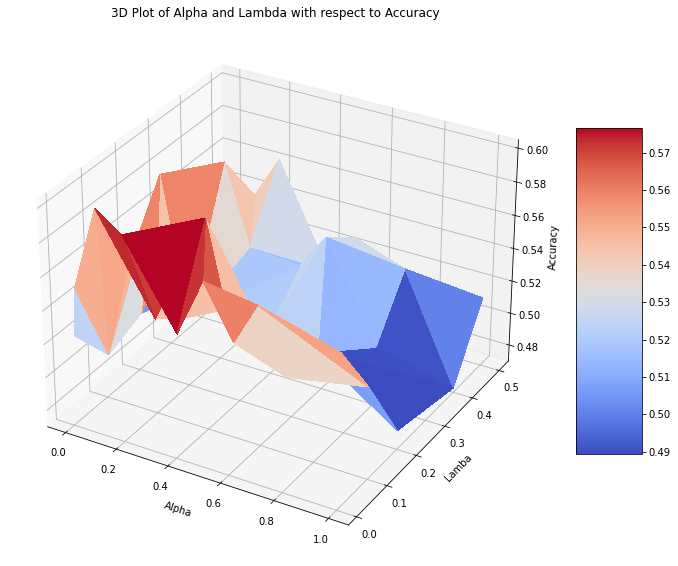

In [36]:
plt.rcParams["figure.figsize"] = (12,12)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_trisurf(l,p,a,linewidth=0, antialiased=False,cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5);
ax.set_title('3D Plot of Alpha and Lambda with respect to Accuracy');
ax.set_xlabel('Alpha')
ax.set_ylabel('Lamba')
ax.set_zlabel('Accuracy');

Retrain the model on the best param and evaluate on Test set

In [37]:
best_log_model = LogisticRegression(X_train_normalized,y_train.values.reshape(-1,1),Loss.L2_regularized_cross_entropy_loss,False)
best_log_model.fit(lr = best_l, penalty=best_p); #best params

In [38]:
best_log_reg_model_test = best_log_model.predict(X_test_normalized) > 0.5
print('The Final Test accuracy of Cross Entropy with L2-Regularized with best params is', accuracy_score(y_test,log_reg_model_test))

The Final Test accuracy of Cross Entropy with L2-Regularized with best params is 0.9824561403508771
